**This project segment aims to conduct a time series analysis on the NYC Motor Accidents dataset, focusing on each borough within monthly intervals. The objective is to develop a time series model capable of forecasting future trends based on the analyzed data.**

#Install/Import Libraries

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import itertools
import re
from geopy.geocoders import Photon
from geopy.extra.rate_limiter import RateLimiter
from enum import Enum
import geopandas as gpd
import geopy
import geocoder
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import datetime

#Analyze dataset

In [ ]:
df = pd.read_csv('Original_Dataset_With_Location_Imputed.csv')
print(df.shape)

In [12]:
df.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'STRTNAME_BOROUGH'],
      dtype='object')

In [13]:
#Check count of rows with missing borough values
df['BOROUGH'].isna().sum()

632860

In [14]:
from enum import Enum

class HelperClass:
    """
    A utility class containing Enums for columns in the NYC Motor Accidents dataset and NYC boroughs.
    """

    class CrashColumns(Enum):
        """
        Enum defining columns in the NYC Motor Accidents dataset.
        """
        CRASH_DATE = 'CRASH DATE'
        CRASH_TIME = 'CRASH TIME'
        BOROUGH = 'BOROUGH'
        ZIP_CODE = 'ZIP CODE'
        LATITUDE = 'LATITUDE'
        LONGITUDE = 'LONGITUDE'
        LOCATION = 'LOCATION'
        ON_STREET_NAME = 'ON STREET NAME'
        CROSS_STREET_NAME = 'CROSS STREET NAME'
        OFF_STREET_NAME = 'OFF STREET NAME'
        NUMBER_OF_PERSONS_INJURED = 'NUMBER OF PERSONS INJURED'
        NUMBER_OF_PERSONS_KILLED = 'NUMBER OF PERSONS KILLED'
        NUMBER_OF_PEDESTRIANS_INJURED = 'NUMBER OF PEDESTRIANS INJURED'
        NUMBER_OF_PEDESTRIANS_KILLED = 'NUMBER OF PEDESTRIANS KILLED'
        NUMBER_OF_CYCLIST_INJURED = 'NUMBER OF CYCLIST INJURED'
        NUMBER_OF_CYCLIST_KILLED = 'NUMBER OF CYCLIST KILLED'
        NUMBER_OF_MOTORIST_INJURED = 'NUMBER OF MOTORIST INJURED'
        NUMBER_OF_MOTORIST_KILLED = 'NUMBER OF MOTORIST KILLED'
        CONTRIBUTING_FACTOR_VEHICLE_1 = 'CONTRIBUTING FACTOR VEHICLE 1'
        CONTRIBUTING_FACTOR_VEHICLE_2 = 'CONTRIBUTING FACTOR VEHICLE 2'
        CONTRIBUTING_FACTOR_VEHICLE_3 = 'CONTRIBUTING FACTOR VEHICLE 3'
        CONTRIBUTING_FACTOR_VEHICLE_4 = 'CONTRIBUTING FACTOR VEHICLE 4'
        CONTRIBUTING_FACTOR_VEHICLE_5 = 'CONTRIBUTING FACTOR VEHICLE 5'
        COLLISION_ID = 'COLLISION_ID'
        VEHICLE_TYPE_CODE_1 = 'VEHICLE TYPE CODE 1'
        VEHICLE_TYPE_CODE_2 = 'VEHICLE TYPE CODE 2'
        VEHICLE_TYPE_CODE_3 = 'VEHICLE TYPE CODE 3'
        VEHICLE_TYPE_CODE_4 = 'VEHICLE TYPE CODE 4'
        VEHICLE_TYPE_CODE_5 = 'VEHICLE TYPE CODE 5'
        STRTNAME_BOROUGH = 'STRTNAME_BOROUGH'

    class NYC_Boroughs(Enum):
        """
        Enum defining NYC boroughs.
        """
        MANHATTAN = 'MANHATTAN'
        BRONX = 'BRONX'
        BROOKLYN = 'BROOKLYN'
        QUEENS = 'QUEENS'
        STATEN_ISLAND = 'STATEN ISLAND'


In [15]:
#Check rows where borough values are missing but have location non NaN
df_Y = df[df[HelperClass.CrashColumns.BOROUGH.value].isna() & ~df[HelperClass.CrashColumns.LOCATION.value].isna()].copy()
len(df_Y)

438439

In [16]:
#Drop rows that have missing borough values from the original dataframe
df = df.drop(df_Y.index)
len(df)

1595866

In [17]:
#Number of unique locations which need borough values to be imputed
#These are the values for which, we would need to call the geolocator API
unique_loc_values = df_Y[HelperClass.CrashColumns.LOCATION.value].unique()
len(unique_loc_values)

56477

Set up API to impute missing Borough values using latitude and longitude.

In [ ]:
geolocator = Nominatim(user_agent="DJ", timeout=10)
rgeocode = RateLimiter(geolocator.reverse, min_delay_seconds=0.2)

#Data Pre-processing/Missing Values Imputation

In this section, we run the reverse geocode API to get the addresses for rows that have missing borough names with their lat, long values.

**Caution: The following code will perform 56k API calls to geocode API. This takes about 6-7 hours to run. Skip the code and go to the "Import Final Dataset" section as we have generated the csv of imputed borough values.**

In [ ]:
# Create a DataFrame with unique values of location
df_unique_loc = pd.DataFrame({HelperClass.CrashColumns.LOCATION.value: unique_loc_values})

df_unique_loc[['Latitude', 'Longitude']] = df_unique_loc[HelperClass.CrashColumns.LOCATION.value].str.extract(r'\(([^,]+),\s*([^)]+)\)')

# Convert the latitude and longitude columns to numeric
df_unique_loc[['Latitude', 'Longitude']] = df_unique_loc[['Latitude', 'Longitude']].apply(pd.to_numeric, errors='coerce')

# Apply the reverse geocoding function
df_unique_loc['location_address'] = df_unique_loc.apply(lambda row: rgeocode((row['Latitude'], row['Longitude'])), axis=1)

# # Merge the original DataFrame with the geocoded results
df_Y = pd.merge(df_Y, df_unique_loc, on=HelperClass.CrashColumns.LOCATION.value, how='left')

csv_file_path = 'missingboroughs_final.csv'

df_Y.to_csv(csv_file_path)

In [21]:
#This dataframe contains rows which originally had missing borough values but we were successfuly able to impute them
df_new = pd.read_csv('missingboroughs_final.csv')
print(df_new.shape)

<ipython-input-21-537716e6083e>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv('/content/drive/MyDrive/FDS_Datasets/missingboroughs_final.csv')


(438439, 34)


In [28]:
df_new['location_address']

0         Brooklyn-Queens Expressway, Williamsburg, Broo...
1         65-47, Myrtle Avenue, Glendale, Queens County,...
2         Belt Parkway, Brooklyn, Kings County, City of ...
3         Whitestone Expressway, Linden Hill, Queens Cou...
4         Long Island Expressway, Queens County, City of...
                                ...                        
438434    80, Saint Nicholas Avenue, Brooklyn, Kings Cou...
438435    130-20, Farmers Boulevard, Queens County, City...
438436    45-12, 220th Street, Oakland Gardens, Queens C...
438437    West Farms Road, West Farms, Bronx County, The...
438438    6401, 6th Avenue, Brooklyn, Kings County, City...
Name: location_address, Length: 438439, dtype: object

In [22]:
df_new['location_address'].isna().sum()

125

In [23]:
#Check rows with (0,0) Lat, Long values(These will be dropped)
count_rows_with_value_0 = df[df['LOCATION'] == '(0.0, 0.0)'].shape[0]
count_rows_with_value_0

3219

In [24]:
boroughs = ['Manhattan', 'Brooklyn', 'Bronx', 'Staten Island', 'Queens']

Extract borough names from location address and impute in Borough Column

In [25]:
for index, row in df_new.iterrows():
    if pd.notna(row['location_address']):
        for borough in boroughs:
            if borough.lower() in row['location_address'].lower():
                df_new.at[index, 'BOROUGH'] = borough
                break

In [26]:
df_new['BOROUGH'].isna().sum()

2535

In [27]:
df_new.head()

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,...,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,STRTNAME_BOROUGH,Latitude,Longitude,location_address
0,0,12/14/2021,17:05,Brooklyn,NaN,40.709183,-73.956825,"(40.709183, -73.956825)","BROOKLYN QUEENS EXPRESSWAY NYC, New York",NaN,...,4486555,Sedan,Tractor Truck Diesel,NaN,NaN,NaN,NaN,40.709183,-73.956825,"Brooklyn-Queens Expressway, Williamsburg, Broo..."
1,1,12/13/2021,0:34,Queens,NaN,40.701275,-73.888870,"(40.701275, -73.88887)","MYRTLE AVENUE NYC, New York",NaN,...,4486934,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,NaN,40.701275,-73.888870,"65-47, Myrtle Avenue, Glendale, Queens County,..."
2,2,12/14/2021,0:59,Brooklyn,NaN,40.596620,-74.002310,"(40.59662, -74.00231)","BELT PARKWAY NYC, New York",NaN,...,4486564,Sedan,NaN,NaN,NaN,NaN,NaN,40.596620,-74.002310,"Belt Parkway, Brooklyn, Kings County, City of ..."
3,3,12/14/2021,14:30,Queens,NaN,40.783268,-73.824850,"(40.783268, -73.82485)","WHITESTONE EXPRESSWAY NYC, New York",NaN,...,4486537,Station Wagon/Sport Utility Vehicle,Sedan,Sedan,NaN,NaN,NaN,40.783268,-73.824850,"Whitestone Expressway, Linden Hill, Queens Cou..."
4,4,12/14/2021,5:46,Queens,NaN,40.744644,-73.770410,"(40.744644, -73.77041)","LONG ISLAND EXPRESSWAY NYC, New York",NaN,...,4487122,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,40.744644,-73.770410,"Long Island Expressway, Queens County, City of..."


In [29]:
#Drop the new columns and transform dataframe into original shape
columns_to_drop = ['Latitude', 'Longitude', 'location_address']
df_new = df_new.drop(columns=columns_to_drop)

In [30]:
df_new.head()

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,STRTNAME_BOROUGH
0,0,12/14/2021,17:05,Brooklyn,NaN,40.709183,-73.956825,"(40.709183, -73.956825)","BROOKLYN QUEENS EXPRESSWAY NYC, New York",NaN,...,NaN,NaN,NaN,4486555,Sedan,Tractor Truck Diesel,NaN,NaN,NaN,NaN
1,1,12/13/2021,0:34,Queens,NaN,40.701275,-73.888870,"(40.701275, -73.88887)","MYRTLE AVENUE NYC, New York",NaN,...,NaN,NaN,NaN,4486934,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,NaN
2,2,12/14/2021,0:59,Brooklyn,NaN,40.596620,-74.002310,"(40.59662, -74.00231)","BELT PARKWAY NYC, New York",NaN,...,NaN,NaN,NaN,4486564,Sedan,NaN,NaN,NaN,NaN,NaN
3,3,12/14/2021,14:30,Queens,NaN,40.783268,-73.824850,"(40.783268, -73.82485)","WHITESTONE EXPRESSWAY NYC, New York",NaN,...,Unspecified,NaN,NaN,4486537,Station Wagon/Sport Utility Vehicle,Sedan,Sedan,NaN,NaN,NaN
4,4,12/14/2021,5:46,Queens,NaN,40.744644,-73.770410,"(40.744644, -73.77041)","LONG ISLAND EXPRESSWAY NYC, New York",NaN,...,NaN,NaN,NaN,4487122,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [31]:
csv_file_path = 'missingboroughs_cleaned.csv'

df_new.to_csv(csv_file_path)

Combine original dataframe with the imputed dataframe

In [32]:
final_dataset = pd.concat([df, df_new], ignore_index=True)

In [33]:
final_dataset['BOROUGH'].isna().sum()

196956

In [34]:
final_dataset.shape

(2034305, 31)

In [35]:
df = final_dataset.dropna(subset=['BOROUGH'])
df.shape

(1837349, 31)

In [ ]:
csv_file_path = 'TimeSeries_Final_Dataset.csv'

df.to_csv(csv_file_path)

#Import Final Dataset

After finishing the imputation and pre processing, this section imports the final transformed dataset

Note: You can skip the data preprocessing and begin running the code from this section.

In [36]:
df = pd.read_csv('TimeSeries_Final_Dataset.csv')
print(df.shape)

<ipython-input-36-d4537b216b5a>:1: DtypeWarning: Columns (4,10,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/FDS_Datasets/final_dataset_timeseries.csv')


(1837349, 32)


In [37]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

In [38]:
df['BOROUGH'] = df['BOROUGH'].str.upper()

#Time series dataframes for each borough

This section creates 5 dataframes, one for each borough that will be later used to fit time series models.

In [39]:
df['MonthYear'] = df['CRASH DATE'].dt.to_period("M").dt.to_timestamp()

borough_dfs = {}

# Iterate over unique boroughs
for borough in df['BOROUGH'].unique():
    # Filter data for the current borough
    borough_data = df[df['BOROUGH'] == borough]

    # Group by month and count accidents
    borough_monthly_counts = borough_data.groupby('MonthYear').size().reset_index(name='accident_count')

    # Add the DataFrame to the dictionary
    borough_dfs[borough] = borough_monthly_counts

In [40]:
Manhattan = borough_dfs['MANHATTAN']
Queens = borough_dfs['QUEENS']
Brooklyn = borough_dfs['BROOKLYN']
Bronx = borough_dfs['BRONX']
SI = borough_dfs['STATEN ISLAND']

In [41]:
Manhattan.set_index('MonthYear', inplace=True)
Queens.set_index('MonthYear', inplace=True)
Brooklyn.set_index('MonthYear', inplace=True)
Bronx.set_index('MonthYear', inplace=True)
SI.set_index('MonthYear', inplace=True)

In [44]:
print(Manhattan.describe())
print(Queens.describe())
print(Brooklyn.describe())
print(Bronx.describe())
print(SI.describe())

       accident_count
count      136.000000
mean      2909.933824
std       1169.869731
min        511.000000
25%       1496.250000
50%       3423.000000
75%       3852.500000
max       4468.000000
       accident_count
count      136.000000
mean      3786.941176
std       1259.871856
min        874.000000
25%       2443.000000
50%       4065.000000
75%       4876.750000
max       5661.000000
       accident_count
count      136.000000
mean      4136.161765
std       1151.768567
min       1092.000000
25%       2970.750000
50%       4326.500000
75%       5037.000000
max       6147.000000
       accident_count
count      136.000000
mean      2020.492647
std        622.794550
min        391.000000
25%       1592.250000
50%       1822.000000
75%       2619.500000
max       3231.000000
       accident_count
count      136.000000
mean       656.389706
std        258.042953
min        184.000000
25%        423.000000
50%        625.500000
75%        911.250000
max       1127.000000


#Time Series Plots - Non Stationary

This section plots the time series graphs for each borough. The X axis has the crash date and Y axis has the count of accidents.

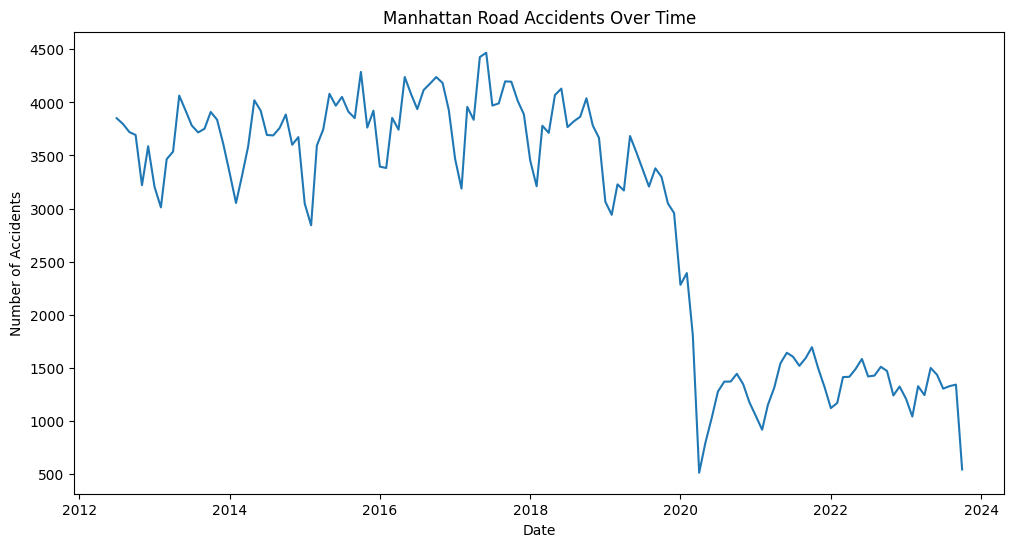

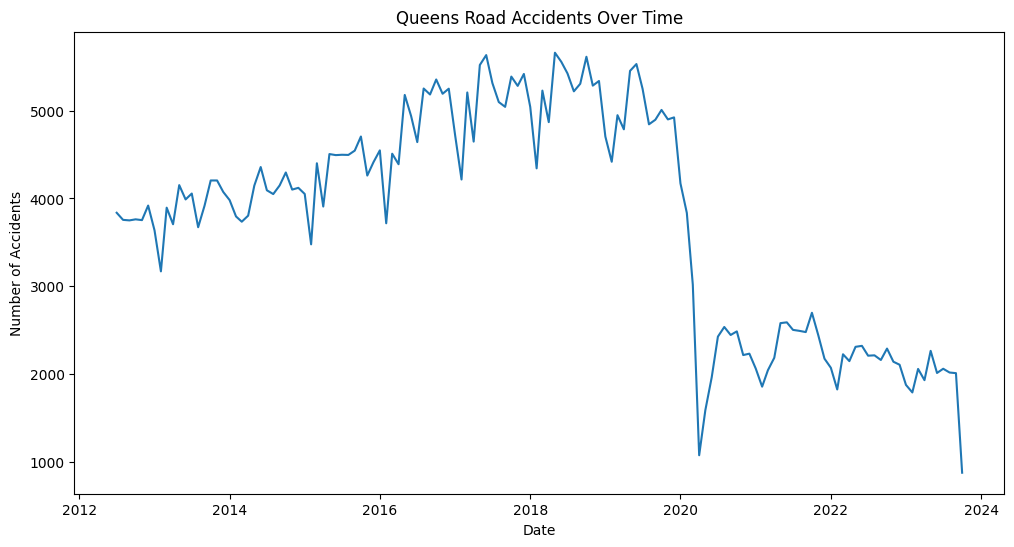

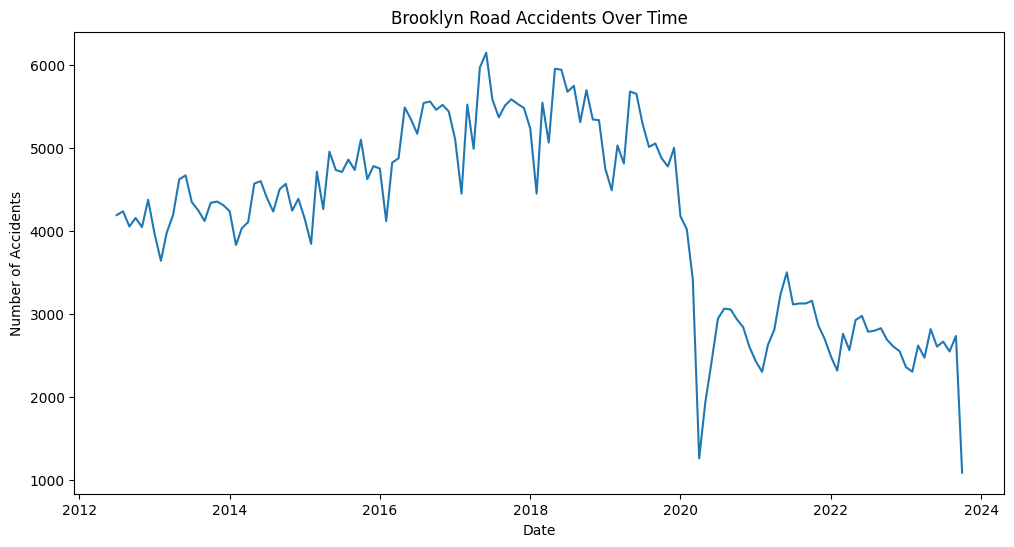

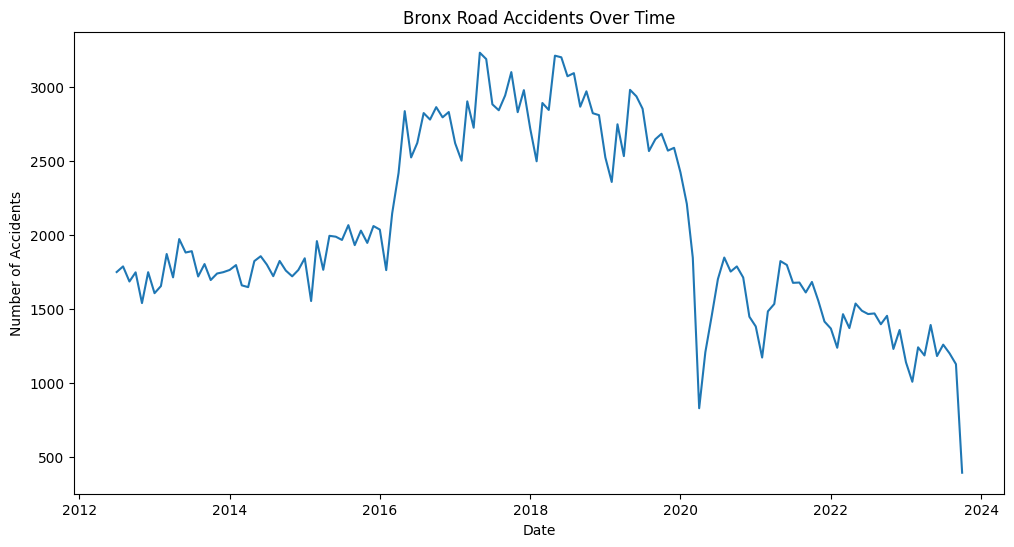

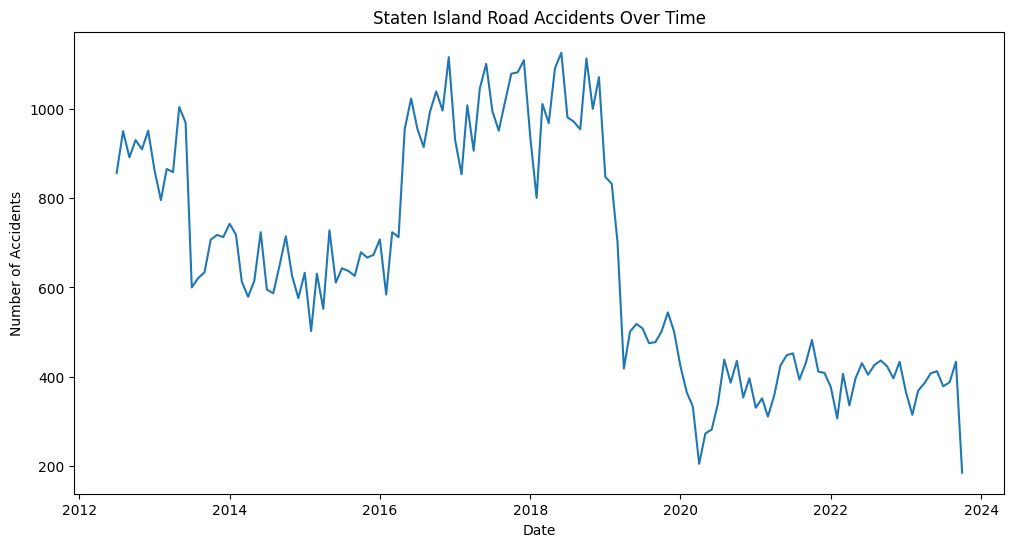

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(Manhattan.index, Manhattan.values)
plt.title('Manhattan Road Accidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(Queens.index, Queens.values)
plt.title('Queens Road Accidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(Brooklyn.index, Brooklyn.values)
plt.title('Brooklyn Road Accidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(Bronx.index, Bronx.values)
plt.title('Bronx Road Accidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(SI.index, SI.values)
plt.title('Staten Island Road Accidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.show()

#AD Fuller Test

We observe that the plots are not stationary through visualization. To confirm it, in this section we run the AD Fuller Test to check the probability(p) of each time series being non-stationary.

In [46]:
adf_result = adfuller(Manhattan)
print('ADF Statistic of Manhattan:', adf_result[0])
print('p-value of Manhattan:', adf_result[1])

adf_result = adfuller(Queens)
print('ADF Statistic of Queens:', adf_result[0])
print('p-value of Queens:', adf_result[1])

adf_result = adfuller(Brooklyn)
print('ADF Statistic of Brooklyn:', adf_result[0])
print('p-value of Brooklyn:', adf_result[1])

adf_result = adfuller(Bronx)
print('ADF Statistic of Bronx:', adf_result[0])
print('p-value of Bronx:', adf_result[1])

adf_result = adfuller(SI)
print('ADF Statistic of SI:', adf_result[0])
print('p-value of SI:', adf_result[1])

ADF Statistic of Manhattan: -0.21245865215248452
p-value of Manhattan: 0.9370201940273953
ADF Statistic of Queens: -0.17559690961125832
p-value of Queens: 0.9413685768031346
ADF Statistic of Brooklyn: -0.27700293447213664
p-value of Brooklyn: 0.9286988434487373
ADF Statistic of Bronx: -0.4339325855465914
p-value of Bronx: 0.9042772351528756
ADF Statistic of SI: -1.4262994489884038
p-value of SI: 0.5696049268417104


**We perform 2nd order differencing to make the time series stationary. After which, we re-run the AD Fuller test.**

In [47]:
time_series_diff_man = Manhattan.diff().diff().dropna()
time_series_diff_bkl = Brooklyn.diff().diff().dropna()
time_series_diff_brx = Bronx.diff().diff().dropna()
time_series_diff_que = Queens.diff().diff().dropna()
time_series_diff_si = SI.diff().diff().dropna()

In [48]:
adf_result = adfuller(time_series_diff_man)
print('ADF Statistic of Manhattan:', adf_result[0])
print('p-value of Manhattan:', adf_result[1])

adf_result = adfuller(time_series_diff_que)
print('ADF Statistic of Queens:', adf_result[0])
print('p-value of Queens:', adf_result[1])

adf_result = adfuller(time_series_diff_bkl)
print('ADF Statistic of Brooklyn:', adf_result[0])
print('p-value of Brooklyn:', adf_result[1])

adf_result = adfuller(time_series_diff_brx)
print('ADF Statistic of Bronx:', adf_result[0])
print('p-value of Bronx:', adf_result[1])

adf_result = adfuller(time_series_diff_si)
print('ADF Statistic of SI:', adf_result[0])
print('p-value of SI:', adf_result[1])

ADF Statistic of Manhattan: -8.807555842122468
p-value of Manhattan: 2.03235478621399e-14
ADF Statistic of Queens: -5.686979041136034
p-value of Queens: 8.236260632474508e-07
ADF Statistic of Brooklyn: -7.731778599182677
p-value of Brooklyn: 1.12041292035409e-11
ADF Statistic of Bronx: -6.162265375082127
p-value of Bronx: 7.126837520969191e-08
ADF Statistic of SI: -7.4692205572273815
p-value of SI: 5.107260676083356e-11


#Time Series Plots - Stationary

After performing differencing, this section replots the time series graphs to visualize the stationary behaviour of the time series.

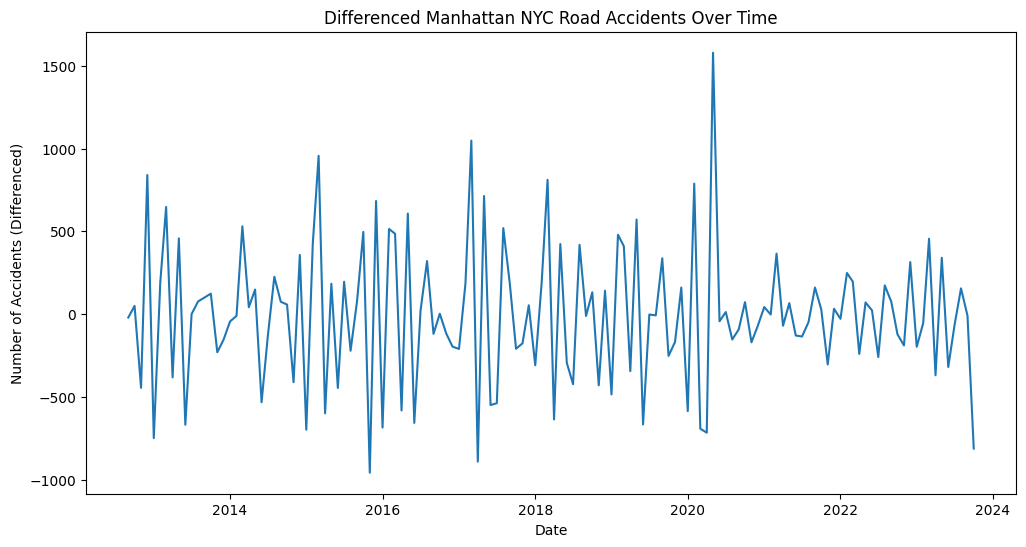

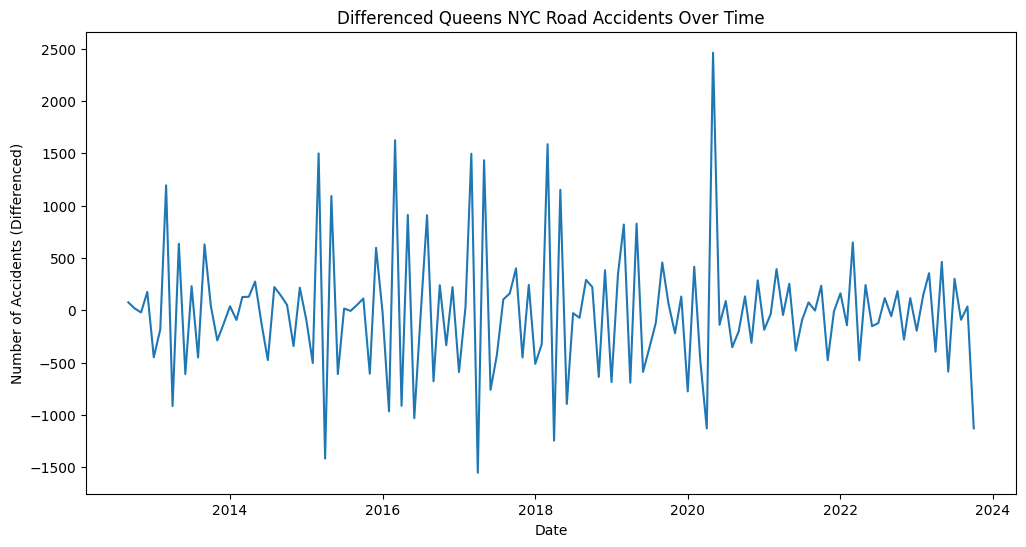

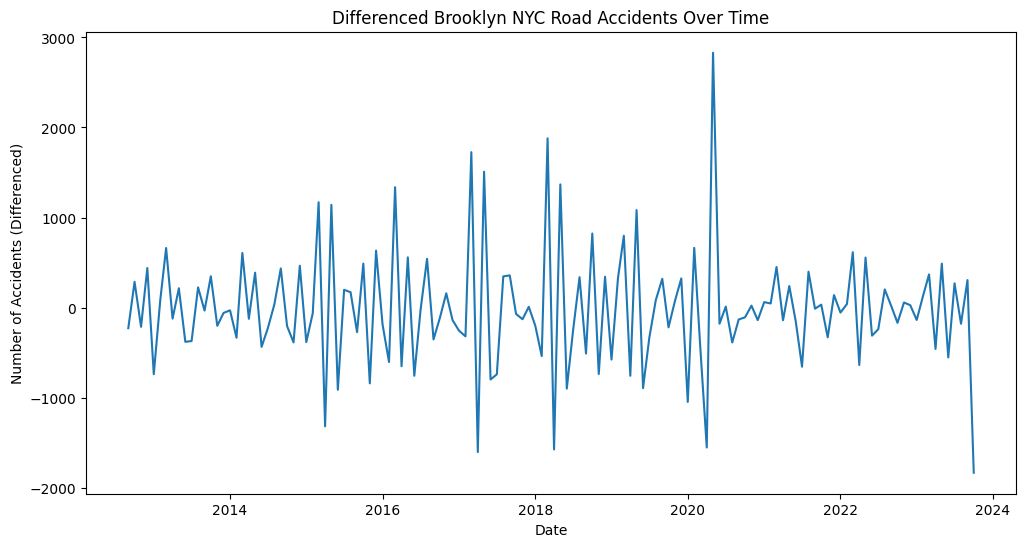

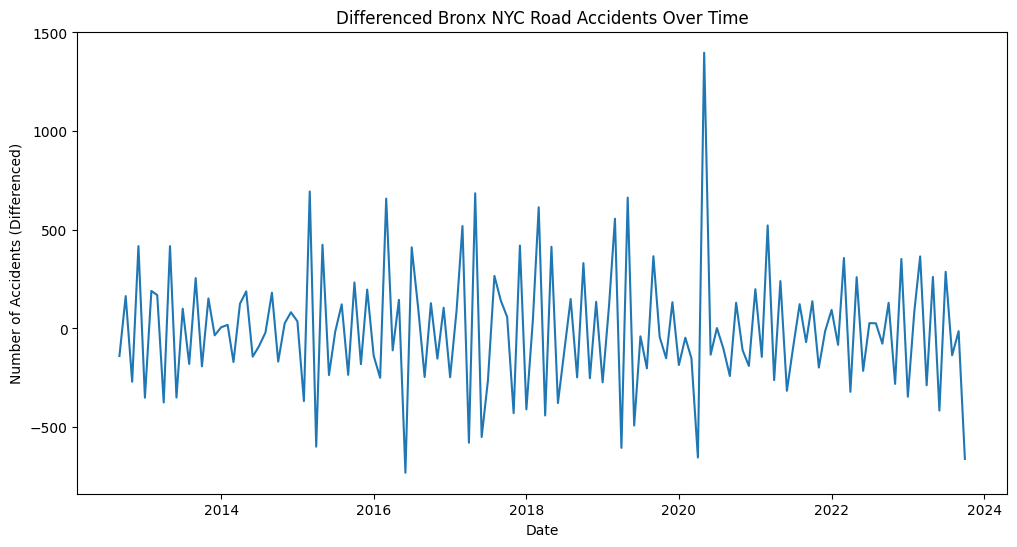

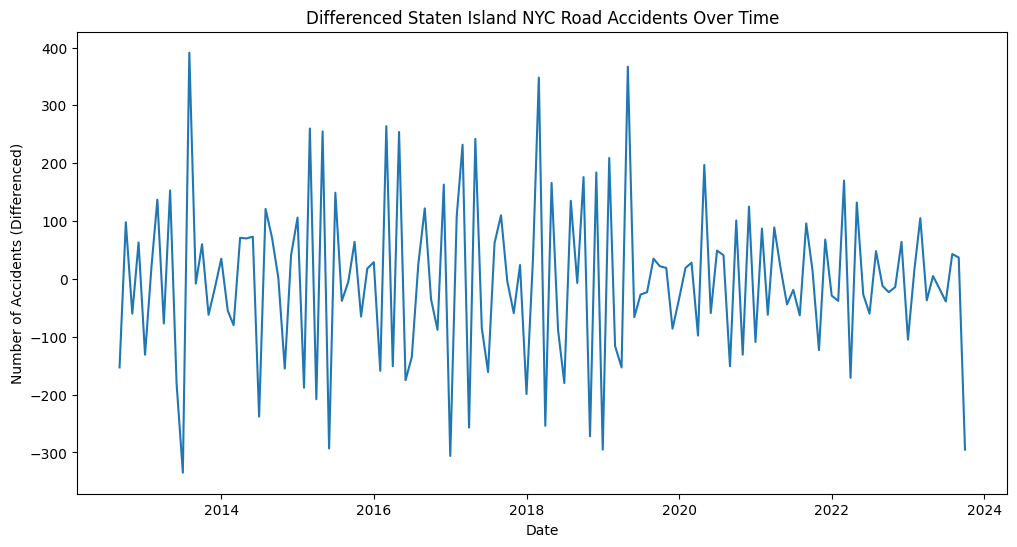

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(time_series_diff_man.index, time_series_diff_man.values)
plt.title('Differenced Manhattan NYC Road Accidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Accidents (Differenced)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_series_diff_que.index, time_series_diff_que.values)
plt.title('Differenced Queens NYC Road Accidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Accidents (Differenced)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_series_diff_bkl.index, time_series_diff_bkl.values)
plt.title('Differenced Brooklyn NYC Road Accidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Accidents (Differenced)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_series_diff_brx.index, time_series_diff_brx.values)
plt.title('Differenced Bronx NYC Road Accidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Accidents (Differenced)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_series_diff_si.index, time_series_diff_si.values)
plt.title('Differenced Staten Island NYC Road Accidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Accidents (Differenced)')
plt.show()

#ACF/PCF Plots

In this section, we try to identify any seasonality in the time series data for each borough to pick the right model for forecasting. We accomplish this using the ACF/PCF plots.

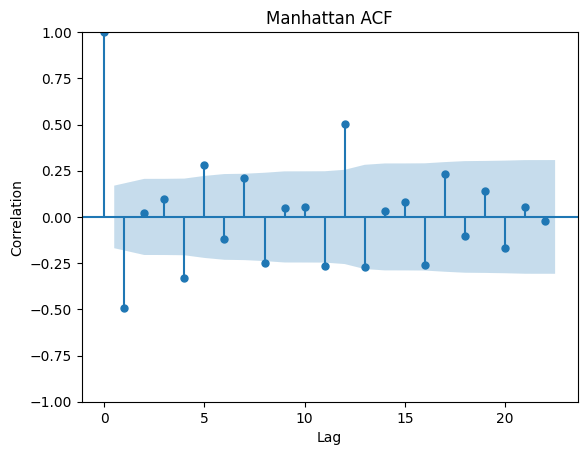

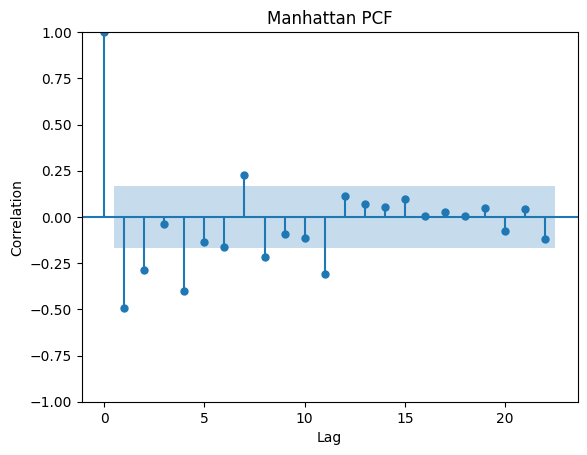

In [53]:
#Manhattan
plot_acf(time_series_diff_man)
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title("Manhattan ACF")
plt.show()

plot_pacf(time_series_diff_man)
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title("Manhattan PCF")
plt.show()

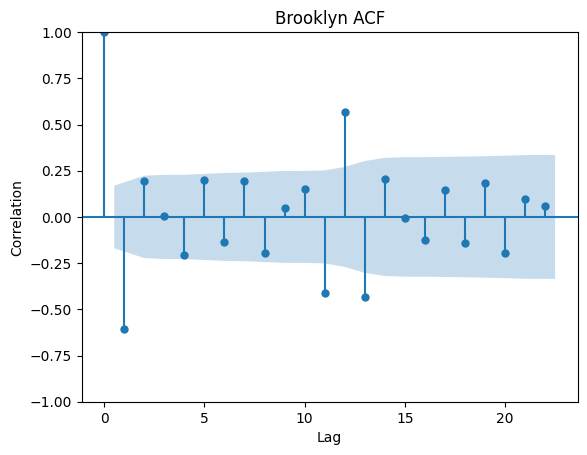

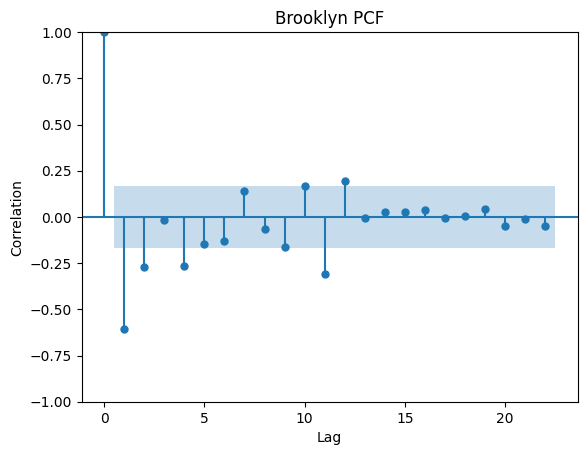

In [54]:
#Brooklyn
plot_acf(time_series_diff_bkl)
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title("Brooklyn ACF")
plt.show()

plot_pacf(time_series_diff_bkl)
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title("Brooklyn PCF")
plt.show()

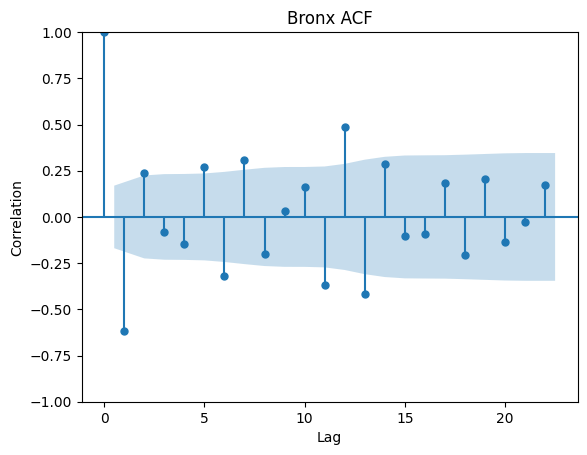

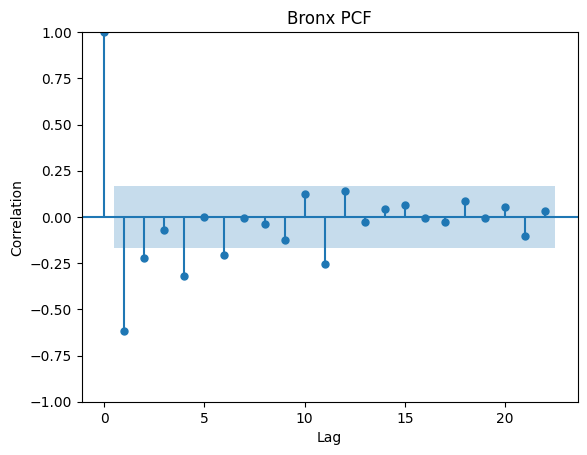

In [55]:
#Bronx
plot_acf(time_series_diff_brx)
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title("Bronx ACF")
plt.show()

plot_pacf(time_series_diff_brx)
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title("Bronx PCF")
plt.show()

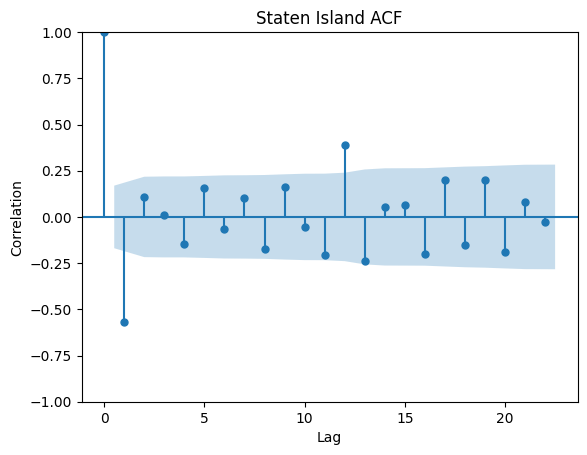

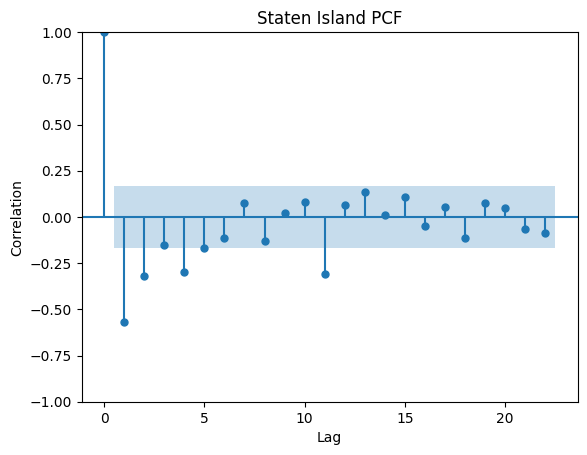

In [56]:
#Staten Island
plot_acf(time_series_diff_si)
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title("Staten Island ACF")
plt.show()

plot_pacf(time_series_diff_si)
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title("Staten Island PCF")
plt.show()

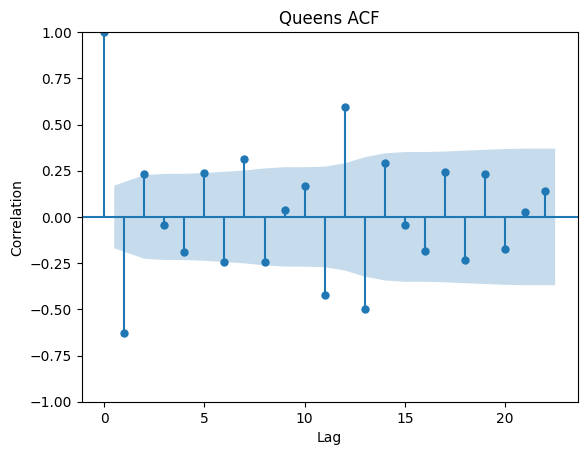

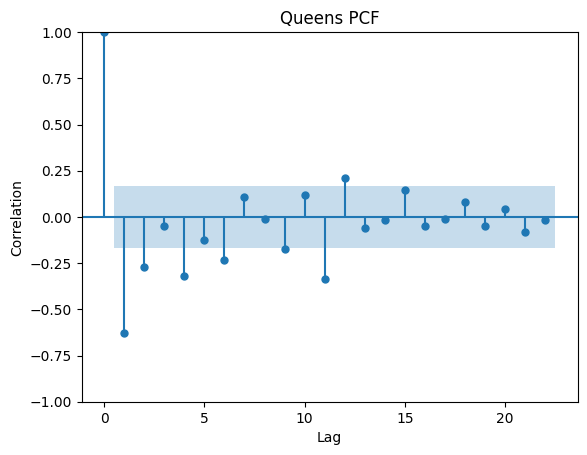

In [57]:
#Queens
plot_acf(time_series_diff_que)
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title("Queens ACF")
plt.show()

plot_pacf(time_series_diff_que)
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title("Queens PCF")
plt.show()

#Fitting and Evaluating ARIMA Models

In this section, we will fit an ARIMA model for each of the boroughs. From the previous section, we observed that there is a seasonality of 12 months in each borough indicating a yearly seasonality in the trends of accidents.

**MANHATTAN**

**Fit the model using auto_arima**

In [58]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

train_size = int(len(Manhattan) * 0.8)  # 80% for training, 20% for testing
train_data, test_data = Manhattan[:train_size], Manhattan[train_size:]

# Use auto_arima to automatically select the best ARIMA or SARIMA model
model = auto_arima(train_data, seasonal=True, m=12, trace=True, maxiter=100)

# Forecast future values on the test set
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1539.904, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1513.567, Time=0.94 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1524.395, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1538.358, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1541.854, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1504.362, Time=1.26 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1502.774, Time=3.67 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1501.599, Time=0.97 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1524.399, Time=0.25 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1501.972, Time=1.80 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1518.504, Time=0.65 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.28 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1499.742, Time=0.66 sec
 ARIMA(0,1,0)(0,0,1)[12] inte

**Visualize the forecast**

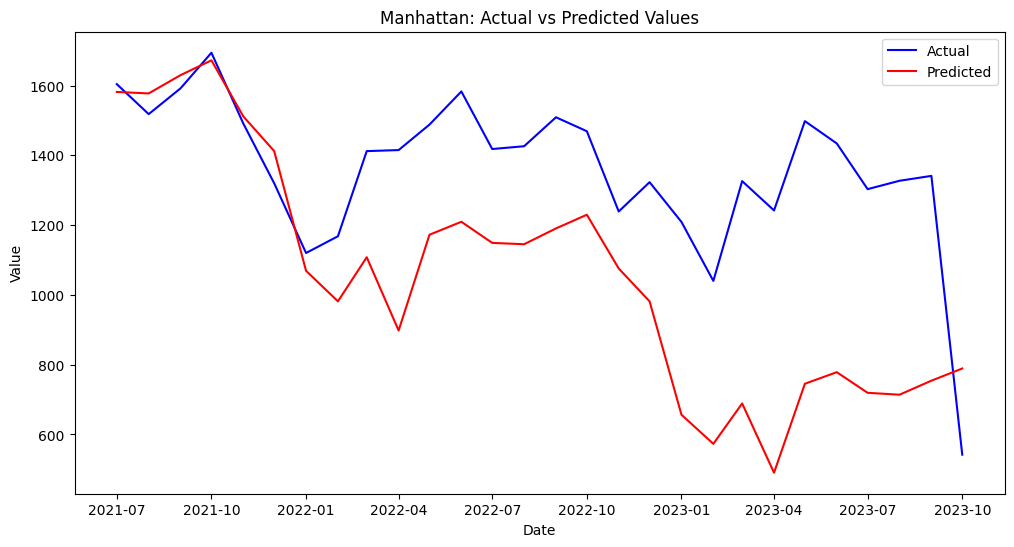

In [59]:
# Plotting the actual test data
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')

# Plotting the predicted values
plt.plot(test_data.index, forecast, label='Predicted', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Manhattan: Actual vs Predicted Values')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

**Evaluate the model**

In [62]:
# Evaluate the model performance using mean absolute error
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)

# Print the results
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

RMSE: 410.4724897508806
MSE: 168487.6648422868
MAE: 337.93783987141086


**Benchmark model that predicts the mean of training data**

In [63]:
mean_predictions = np.full_like(test_data, fill_value=np.mean(train_data))

# Calculate RMSE of the mean
rmse_mean = np.sqrt(mean_squared_error(test_data, mean_predictions))

print(f"RMSE of the mean: {rmse_mean}")

RMSE of the mean: 1965.170939493196


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


**BROOKLYN**

Fit the model using auto_arima

In [64]:
train_size = int(len(Brooklyn) * 0.8)  # 80% for training, 20% for testing
train_data, test_data = Brooklyn[:train_size], Brooklyn[train_size:]

# Use auto_arima to automatically select the best ARIMA or SARIMA model
model = auto_arima(train_data, seasonal=True, m=12, trace=True, maxiter=100)

# Forecast future values on the test set
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1793.092, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1600.875, Time=0.44 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1685.256, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2131.000, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1623.876, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1590.330, Time=2.41 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1599.024, Time=1.42 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1590.840, Time=1.12 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1767.380, Time=1.28 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=1592.326, Time=4.71 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=1592.327, Time=4.61 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=1699.690, Time=1.44 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=inf, Time=3.14 sec
 ARIMA(1,0,0)(2,0,0)[12]     

**Visualize the forecast**

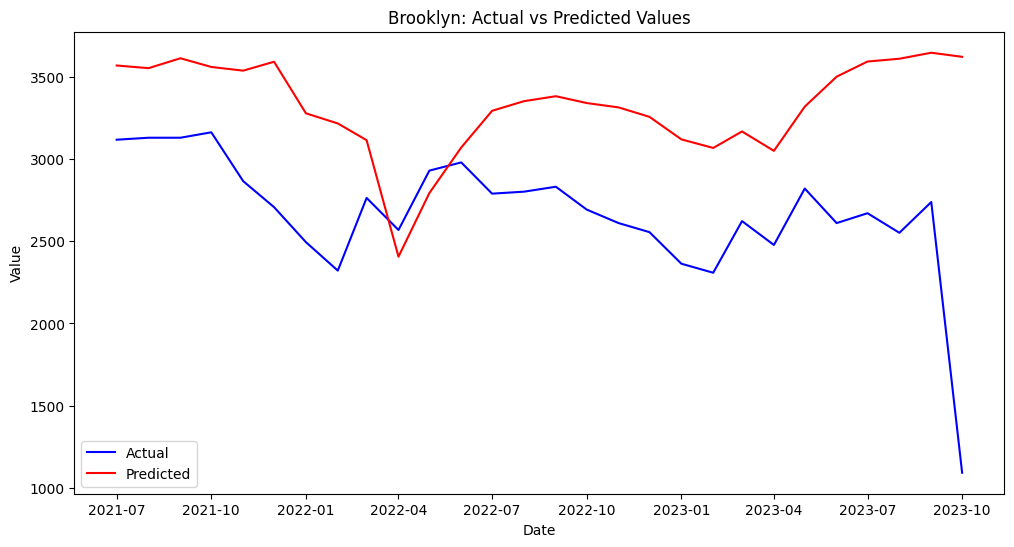

In [65]:
# Plotting the actual test data
plt.figure(figsize=(12,6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')

# Plotting the predicted values
plt.plot(test_data.index, forecast, label='Predicted', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Brooklyn: Actual vs Predicted Values')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

**Evaluate the model**

In [66]:
# Evaluate the model performance using mean absolute error
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)

# Print the results
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

RMSE: 798.8475962744347
MSE: 638157.4820734423
MAE: 672.3393369231932


**Benchmark model that predicts the mean of training data**

In [67]:
mean_predictions = np.full_like(test_data, fill_value=np.mean(train_data))

# Calculate RMSE of the mean
rmse_mean = np.sqrt(mean_squared_error(test_data, mean_predictions))

print(f"RMSE of the mean: {rmse_mean}")

RMSE of the mean: 1887.728150828019


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


**THE BRONX**

**Fit the model using auto_arima**

In [68]:
train_size = int(len(Bronx) * 0.8)  # 80% for training, 20% for testing
train_data, test_data = Bronx[:train_size], Bronx[train_size:]

# Use auto_arima to automatically select the best ARIMA or SARIMA model
model = auto_arima(train_data, seasonal=True, m=12, trace=True, maxiter=100)

# Forecast future values on the test set
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1440.493, Time=2.00 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1461.388, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1449.817, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1454.180, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1459.389, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=2.77 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=5.36 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=9.67 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=5.99 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1464.096, Time=1.11 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=6.71 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=3.75 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=14.75 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.73 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=1442.571, Time=

**Visualize the forecast**

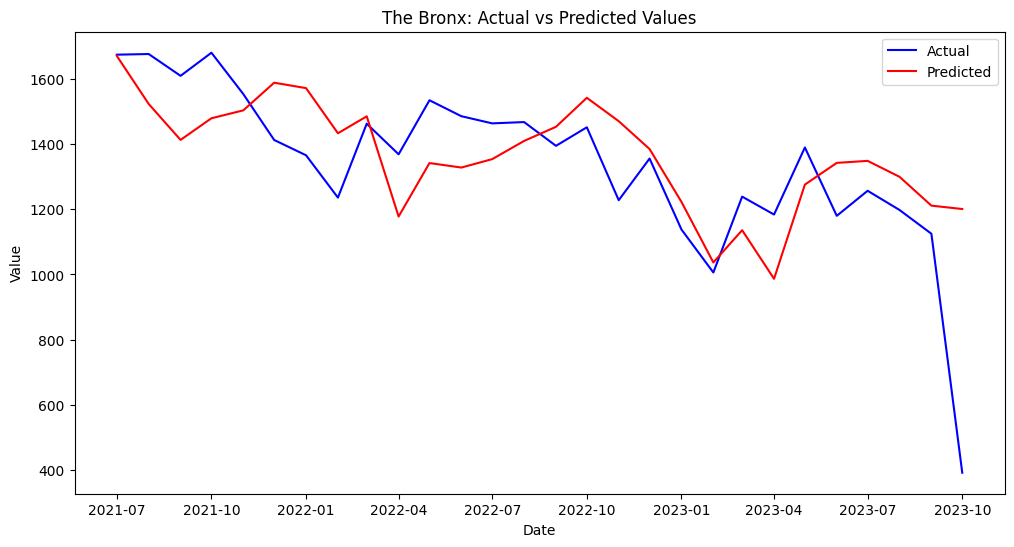

In [69]:
# Plotting the actual test data
plt.figure(figsize=(12,6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')

# Plotting the predicted values
plt.plot(test_data.index, forecast, label='Predicted', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('The Bronx: Actual vs Predicted Values')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

**Evaluate the model**

In [70]:
# Evaluate the model performance using mean squared error

rmse = np.sqrt(mean_squared_error(test_data, forecast))
mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)

# Print the results
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

RMSE: 205.56671958002917
MSE: 42257.676198894354
MAE: 147.1701752703078


**Benchmark model that predicts the mean of training data**

In [71]:
mean_predictions = np.full_like(test_data, fill_value=np.mean(train_data))

# Calculate RMSE of the mean
rmse_mean = np.sqrt(mean_squared_error(test_data, mean_predictions))

print(f"RMSE of the mean: {rmse_mean}")

RMSE of the mean: 892.2508455745904


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


**QUEENS**

**Fit the model using auto_arima**

In [72]:
train_size = int(len(Queens) * 0.8)  # 80% for training, 20% for testing
train_data, test_data = Queens[:train_size], Queens[train_size:]

# Use auto_arima to automatically select the best ARIMA or SARIMA model
model = auto_arima(train_data, seasonal=True, m=12, trace=True, maxiter=100)

# Forecast future values on the test set
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.98 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1809.066, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1591.678, Time=2.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1700.633, Time=1.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2117.646, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1617.386, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1580.219, Time=4.67 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1582.168, Time=4.33 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1582.614, Time=1.79 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1790.468, Time=1.86 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=1581.775, Time=3.09 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=1581.804, Time=5.72 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=1712.655, Time=2.95 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=1583.098, Time=4.90 sec
 ARIMA(1,0,0)(2,0,0)[12]

**Visualize the forecast**

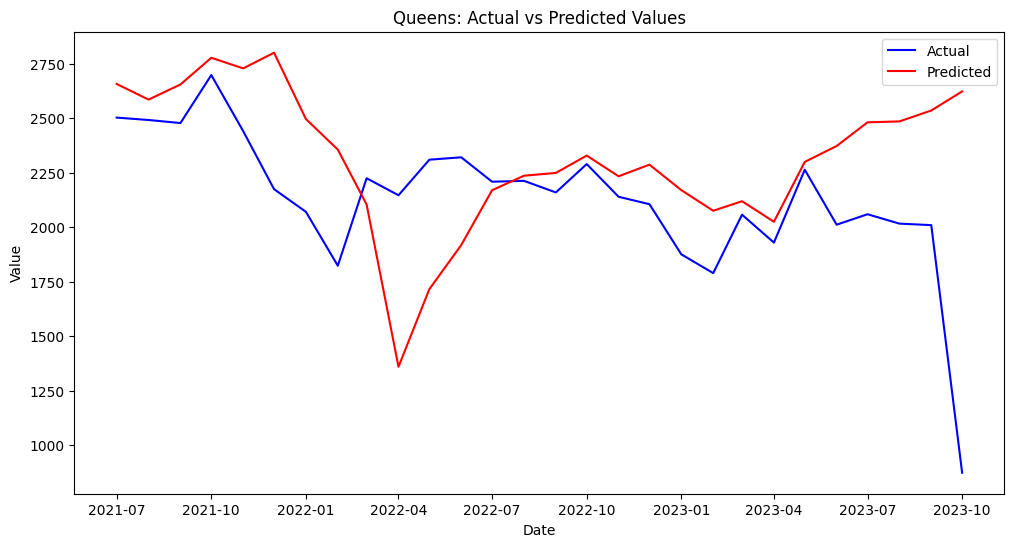

In [73]:
# Plotting the actual test data
plt.figure(figsize=(12,6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')

# Plotting the predicted values
plt.plot(test_data.index, forecast, label='Predicted', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Queens: Actual vs Predicted Values')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

**Evaluate the model**

In [74]:
# Evaluate the model performance using mean squared error
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)

# Print the results
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

RMSE: 472.43607046358466
MSE: 223195.84067507315
MAE: 322.8607923899363


**Benchmark model that predicts the mean of training data**

In [75]:
mean_predictions = np.full_like(test_data, fill_value=np.mean(train_data))

# Calculate RMSE of the mean
rmse_mean = np.sqrt(mean_squared_error(test_data, mean_predictions))

print(f"RMSE of the mean: {rmse_mean}")

RMSE of the mean: 2109.6623037145746


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


**STATEN ISLAND**

**Fit the model using auto_arima**

In [76]:
train_size = int(len(SI) * 0.8)  # 80% for training, 20% for testing
train_data, test_data = SI[:train_size], SI[train_size:]

# Use auto_arima to automatically select the best ARIMA or SARIMA model
model = auto_arima(train_data, seasonal=True, m=12, trace=True, maxiter=100)

# Forecast future values on the test set
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=5.22 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1287.127, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1264.781, Time=1.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1271.466, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1285.292, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1284.565, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1264.794, Time=1.13 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1264.377, Time=0.48 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1271.348, Time=0.21 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1265.631, Time=1.65 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1264.756, Time=2.11 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=6.52 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1265.544, Time=1.66 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept

**Visualize the forecast**

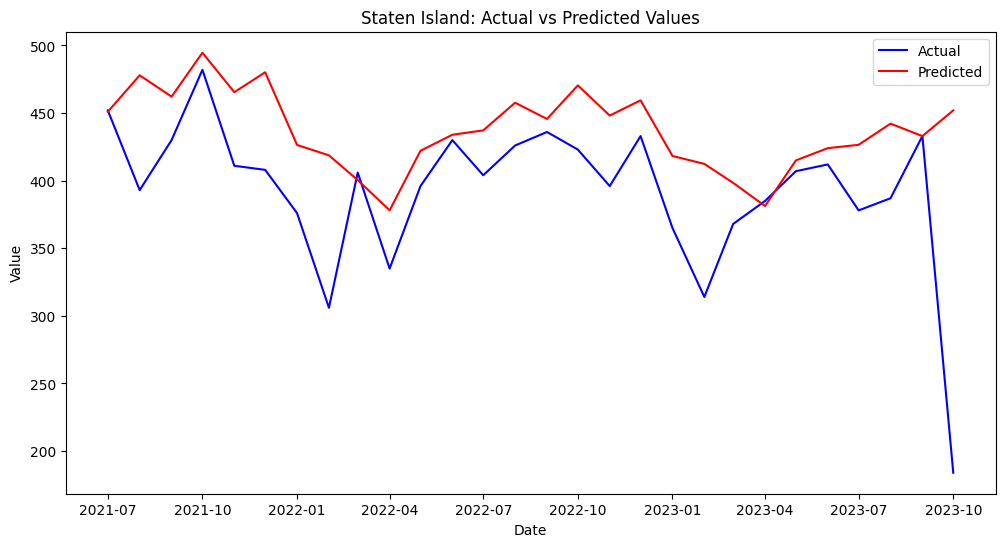

In [77]:
# Plotting the actual test data
plt.figure(figsize=(12,6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')

# Plotting the predicted values
plt.plot(test_data.index, forecast, label='Predicted', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Staten Island: Actual vs Predicted Values')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

**Evaluate the model**

In [78]:
# Evaluate the model performance using mean squared error
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)

# Print the results
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

RMSE: 68.95929399704929
MSE: 4755.384228571477
MAE: 45.613860248360574


**Benchmark model that predicts the mean of training data**

In [79]:
mean_predictions = np.full_like(test_data, fill_value=np.mean(train_data))

# Calculate RMSE of the mean
rmse_mean = np.sqrt(mean_squared_error(test_data, mean_predictions))

print(f"RMSE of the mean: {rmse_mean}")

RMSE of the mean: 336.56425835195273


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
